# Popularity of Movie Genres Based on Box Office Revenue Over Three Decades (1990 - 2020) in the United States

In [1]:
# Dependencies and Setup
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy import stats
from scipy.stats import linregress
import scipy.stats as st
import sys
# from config import api_key
import json
import requests

# Load the data file, read and display it with Pandas
movies_data = Path("imdb_movies.csv")

# Set global float formatting to increase readability
pd.options.display.float_format = '{:,.2f}'.format

# Read and store into Pandas DataFrames
movies_df = pd.read_csv(movies_data)
movies_df.head()

,names,date_x,score,genre,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country
0,Creed III,03/02/2023,73.00,"Drama, Action","After dominating the boxing world, Adonis Cree...","Michael B. Jordan, Adonis Creed, Tessa Thompso...",Creed III,Released,English,"75,000,000.00","271,616,668.00",AU
1,Avatar: The Way of Water,12/15/2022,78.00,"Science Fiction, Adventure, Action",Set more than a decade after the events of the...,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...",Avatar: The Way of Water,Released,English,"460,000,000.00","2,316,794,914.00",AU
2,The Super Mario Bros. Movie,04/05/2023,76.00,"Animation, Adventure, Family, Fantasy, Comedy","While working underground to fix a water main,...","Chris Pratt, Mario (voice), Anya Taylor-Joy, P...",The Super Mario Bros. Movie,Released,English,"100,000,000.00","724,459,031.00",AU
3,Mummies,01/05/2023,70.00,"Animation, Comedy, Family, Adventure, Fantasy","Through a series of unfortunate events, three ...","Óscar Barberán, Thut (voice), Ana Esther Albor...",Momias,Released,"Spanish, Castilian","12,300,000.00","34,200,000.00",AU
4,Supercell,03/17/2023,61.00,Action,Good-hearted teenager William always lived in ...,"Skeet Ulrich, Roy Cameron, Anne Heche, Dr Quin...",Supercell,Released,English,"77,000,000.00","340,941,958.60",US


# Trim the unnecessary information and setup a new data frame standardized column names and simplify the date column to only reflect the year the movies were released

In [2]:
# Trim the columns of data to the one we need
movies_df_trim = movies_df.drop(["overview","crew","orig_title","status","country","budget_x", "score"], axis=1)
#movies_df_reduced

# Rename the column name to be more user friendly
movies_df_trim = movies_df_trim.rename(columns={
    "names":"Name",
    "date_x":"Year",
    "genre":"Genre",
    "orig_lang":"Language",
    "revenue":"Revenue",
})

#Edit the "Year" column to remove the day and month
movies_df_trim.loc[:,"Year"]=pd.to_datetime(movies_df_trim["Year"], errors='coerce').dt.year.astype(int)
movies_df_trim

,Name,Year,Genre,Language,Revenue
0,Creed III,2023,"Drama, Action",English,"271,616,668.00"
1,Avatar: The Way of Water,2022,"Science Fiction, Adventure, Action",English,"2,316,794,914.00"
2,The Super Mario Bros. Movie,2023,"Animation, Adventure, Family, Fantasy, Comedy",English,"724,459,031.00"
3,Mummies,2023,"Animation, Comedy, Family, Adventure, Fantasy","Spanish, Castilian","34,200,000.00"
4,Supercell,2023,Action,English,"340,941,958.60"
...,...,...,...,...,...
10173,20th Century Women,2016,Drama,English,"9,353,729.00"
10174,Delta Force 2: The Colombian Connection,1990,Action,English,"6,698,361.00"
10175,The Russia House,1990,"Drama, Thriller, Romance",English,"22,997,992.00"
10176,Darkman II: The Return of Durant,1995,"Action, Adventure, Science Fiction, Thriller, ...",English,"475,661,306.00"


# Remove duplicated movies, excess characters and white space from the columns of text, non-applicable data from columns of numbers, and movies that genereated zero revenue

In [3]:
#Remove duplicate movie names with the same year
movies_df_cleaned = movies_df_trim.drop_duplicates(subset=["Name","Year"],keep=False)
movies_df_cleaned.reset_index(drop=True, inplace = True)
movies_df_cleaned

,Name,Year,Genre,Language,Revenue
0,Creed III,2023,"Drama, Action",English,"271,616,668.00"
1,Avatar: The Way of Water,2022,"Science Fiction, Adventure, Action",English,"2,316,794,914.00"
2,The Super Mario Bros. Movie,2023,"Animation, Adventure, Family, Fantasy, Comedy",English,"724,459,031.00"
3,Mummies,2023,"Animation, Comedy, Family, Adventure, Fantasy","Spanish, Castilian","34,200,000.00"
4,Supercell,2023,Action,English,"340,941,958.60"
...,...,...,...,...,...
9806,20th Century Women,2016,Drama,English,"9,353,729.00"
9807,Delta Force 2: The Colombian Connection,1990,Action,English,"6,698,361.00"
9808,The Russia House,1990,"Drama, Thriller, Romance",English,"22,997,992.00"
9809,Darkman II: The Return of Durant,1995,"Action, Adventure, Science Fiction, Thriller, ...",English,"475,661,306.00"


In [4]:
# Remove the excess characters in the Genre column
movies_df_cleaned.loc[:,'Genre'] = movies_df_cleaned['Genre'].str.replace('\xa0', '')
movies_df_cleaned['Genre'].unique()
movies_df_cleaned

,Name,Year,Genre,Language,Revenue
0,Creed III,2023,"Drama,Action",English,"271,616,668.00"
1,Avatar: The Way of Water,2022,"Science Fiction,Adventure,Action",English,"2,316,794,914.00"
2,The Super Mario Bros. Movie,2023,"Animation,Adventure,Family,Fantasy,Comedy",English,"724,459,031.00"
3,Mummies,2023,"Animation,Comedy,Family,Adventure,Fantasy","Spanish, Castilian","34,200,000.00"
4,Supercell,2023,Action,English,"340,941,958.60"
...,...,...,...,...,...
9806,20th Century Women,2016,Drama,English,"9,353,729.00"
9807,Delta Force 2: The Colombian Connection,1990,Action,English,"6,698,361.00"
9808,The Russia House,1990,"Drama,Thriller,Romance",English,"22,997,992.00"
9809,Darkman II: The Return of Durant,1995,"Action,Adventure,Science Fiction,Thriller,Horror",English,"475,661,306.00"


In [5]:
#Remove blank space in around the words in the Language column
movies_df_cleaned["Language"] = movies_df_cleaned["Language"].str.lstrip().str.rstrip()

movies_df_cleaned

/var/folders/2b/8jxdb5w95z9d5h81xryzsss00000gn/T/ipykernel_66584/2365003184.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df_cleaned["Language"] = movies_df_cleaned["Language"].str.lstrip().str.rstrip()


,Name,Year,Genre,Language,Revenue
0,Creed III,2023,"Drama,Action",English,"271,616,668.00"
1,Avatar: The Way of Water,2022,"Science Fiction,Adventure,Action",English,"2,316,794,914.00"
2,The Super Mario Bros. Movie,2023,"Animation,Adventure,Family,Fantasy,Comedy",English,"724,459,031.00"
3,Mummies,2023,"Animation,Comedy,Family,Adventure,Fantasy","Spanish, Castilian","34,200,000.00"
4,Supercell,2023,Action,English,"340,941,958.60"
...,...,...,...,...,...
9806,20th Century Women,2016,Drama,English,"9,353,729.00"
9807,Delta Force 2: The Colombian Connection,1990,Action,English,"6,698,361.00"
9808,The Russia House,1990,"Drama,Thriller,Romance",English,"22,997,992.00"
9809,Darkman II: The Return of Durant,1995,"Action,Adventure,Science Fiction,Thriller,Horror",English,"475,661,306.00"


In [6]:
#Remove any non-applicable date from the Revenue columns 
movies_df_cleaned.loc[:, ['Revenue']] = movies_df_cleaned['Revenue'].apply(pd.to_numeric, errors="coerce")
movies_df_cleaned_xtra = movies_df_cleaned.dropna()
movies_df_cleaned_xtra

,Name,Year,Genre,Language,Revenue
0,Creed III,2023,"Drama,Action",English,"271,616,668.00"
1,Avatar: The Way of Water,2022,"Science Fiction,Adventure,Action",English,"2,316,794,914.00"
2,The Super Mario Bros. Movie,2023,"Animation,Adventure,Family,Fantasy,Comedy",English,"724,459,031.00"
3,Mummies,2023,"Animation,Comedy,Family,Adventure,Fantasy","Spanish, Castilian","34,200,000.00"
4,Supercell,2023,Action,English,"340,941,958.60"
...,...,...,...,...,...
9806,20th Century Women,2016,Drama,English,"9,353,729.00"
9807,Delta Force 2: The Colombian Connection,1990,Action,English,"6,698,361.00"
9808,The Russia House,1990,"Drama,Thriller,Romance",English,"22,997,992.00"
9809,Darkman II: The Return of Durant,1995,"Action,Adventure,Science Fiction,Thriller,Horror",English,"475,661,306.00"


In [7]:
# Filter to only movies with positive revenue
revenue_positive = movies_df_cleaned_xtra.loc[movies_df_cleaned_xtra["Revenue"]>0]
revenue_positive

,Name,Year,Genre,Language,Revenue
0,Creed III,2023,"Drama,Action",English,"271,616,668.00"
1,Avatar: The Way of Water,2022,"Science Fiction,Adventure,Action",English,"2,316,794,914.00"
2,The Super Mario Bros. Movie,2023,"Animation,Adventure,Family,Fantasy,Comedy",English,"724,459,031.00"
3,Mummies,2023,"Animation,Comedy,Family,Adventure,Fantasy","Spanish, Castilian","34,200,000.00"
4,Supercell,2023,Action,English,"340,941,958.60"
...,...,...,...,...,...
9806,20th Century Women,2016,Drama,English,"9,353,729.00"
9807,Delta Force 2: The Colombian Connection,1990,Action,English,"6,698,361.00"
9808,The Russia House,1990,"Drama,Thriller,Romance",English,"22,997,992.00"
9809,Darkman II: The Return of Durant,1995,"Action,Adventure,Science Fiction,Thriller,Horror",English,"475,661,306.00"


# Filter the data to the date range we are focused on and edit it down to only English language movies

In [8]:
# Filter out rows with invalid dates
revenue_positive = revenue_positive.dropna(subset=["Year"])

# Years we're looking for from 1990 to 2019 (three decades)
start_year = 1990
end_year = 2019

# Filter the DataFrame based on years 
date_filter_df = revenue_positive.loc[(revenue_positive["Year"] >= start_year) & (revenue_positive["Year"] <= end_year)]
date_filter_df

,Name,Year,Genre,Language,Revenue
22,The Passion of the Christ,2004,Drama,English,"622,313,635.00"
35,John Wick: Chapter 2,2017,"Action,Thriller,Crime",English,"171,539,887.00"
39,John Wick: Chapter 3 - Parabellum,2019,"Action,Thriller,Crime",English,"326,709,727.00"
58,A Bronx Tale,1994,"Drama,Crime",English,"17,287,898.00"
61,The Forbidden Legend: Sex & Chopsticks 2,2009,"Comedy,Drama,Romance",Cantonese,"318,375,960.20"
...,...,...,...,...,...
9804,The Seven Deadly Sins: Prisoners of the Sky,2018,"Action,Adventure,Fantasy,Animation",Japanese,"706,002,070.80"
9806,20th Century Women,2016,Drama,English,"9,353,729.00"
9807,Delta Force 2: The Colombian Connection,1990,Action,English,"6,698,361.00"
9808,The Russia House,1990,"Drama,Thriller,Romance",English,"22,997,992.00"


In [9]:
#Create a data frame with only English Movies
english_movies_df = date_filter_df.loc[date_filter_df["Language"] == "English"]
english_movies_df

,Name,Year,Genre,Language,Revenue
22,The Passion of the Christ,2004,Drama,English,"622,313,635.00"
35,John Wick: Chapter 2,2017,"Action,Thriller,Crime",English,"171,539,887.00"
39,John Wick: Chapter 3 - Parabellum,2019,"Action,Thriller,Crime",English,"326,709,727.00"
58,A Bronx Tale,1994,"Drama,Crime",English,"17,287,898.00"
68,Avatar,2009,"Action,Adventure,Fantasy,Science Fiction",English,"2,923,706,026.00"
...,...,...,...,...,...
9803,The Love Guru,2008,"Comedy,Romance",English,"40,159,017.00"
9806,20th Century Women,2016,Drama,English,"9,353,729.00"
9807,Delta Force 2: The Colombian Connection,1990,Action,English,"6,698,361.00"
9808,The Russia House,1990,"Drama,Thriller,Romance",English,"22,997,992.00"


# Calculate CPI adjusted values for Revenue so we can accurately compare dollar values across the date range we are focused on

In [10]:
# CPI data for the years 1990 to 2024
cpi_data = {
    1990: 130.7,
    1991: 136.2,
    1992: 140.3,
    1993: 144.5,
    1994: 148.2,
    1995: 152.4,
    1996: 156.9,
    1997: 160.5,
    1998: 163.0,
    1999: 166.6,
    2000: 172.2,
    2001: 177.1,
    2002: 179.9,
    2003: 184.0,
    2004: 188.9,
    2005: 195.3,
    2006: 201.6,
    2007: 207.342,
    2008: 215.303,
    2009: 214.537,
    2010: 218.056,
    2011: 224.939,
    2012: 229.594,
    2013: 232.957,
    2014: 236.736,
    2015: 237.017,
    2016: 240.007,
    2017: 245.120,
    2018: 251.107,
    2019: 255.657,
    2020: 258.811,
    2021: 265.056,
    2022: 271.937,
    2023: 278.521,
    2024: 285.595  # CPI for 2024 is projected
}

CPI_df = pd.DataFrame(english_movies_df)

# Function to adjust the dollar value based on CPI
def adjust_dollar_value(row, column_name, base_year):
    cpi_ratio = cpi_data[2024] / cpi_data[base_year]  # CPI ratio from base year to 2024
    return row[column_name] * cpi_ratio

# Replace the values in the existing Revenue Column with the CPI adjusted revenues
CPI_df['Revenue'] = CPI_df.apply(lambda row: '{:,.2f}'.format(adjust_dollar_value(row, 'Revenue', row['Year'])), axis=1)

# # Apply adjustment to Budget, Revenue, and Profit columns
# CPI_df.insert(5, 'Revenue_2024', CPI_df.apply(lambda row: '{:,.2f}'.format(adjust_dollar_value(row, 'Revenue', row['Year'])), axis=1))

# Print the DataFrame with adjusted values
CPI_df

# Export the movies data for English with CPI taken into account
#english_movies_data_CPI = CPI_df.to_csv("English_Movies_Data_CPI.csv", index=False)

,Name,Year,Genre,Language,Revenue
22,The Passion of the Christ,2004,Drama,English,"940,866,398.03"
35,John Wick: Chapter 2,2017,"Action,Thriller,Crime",English,"199,865,102.92"
39,John Wick: Chapter 3 - Parabellum,2019,"Action,Thriller,Crime",English,"364,968,158.44"
58,A Bronx Tale,1994,"Drama,Crime",English,"33,315,365.92"
68,Avatar,2009,"Action,Adventure,Fantasy,Science Fiction",English,"3,892,083,055.58"
...,...,...,...,...,...
9803,The Love Guru,2008,"Comedy,Romance",English,"53,270,109.85"
9806,20th Century Women,2016,Drama,English,"11,130,418.00"
9807,Delta Force 2: The Colombian Connection,1990,Action,English,"14,636,713.16"
9808,The Russia House,1990,"Drama,Thriller,Romance",English,"50,253,339.90"


# In order to provide revenue data for the individual genres we need to seperate the information in the genre column from the existing frame and create new columns that reflect the different sub-genres for each movie. As well, we need a column that tracks the number of sub-genres per movie so we can divide the revenue equitably.

In [11]:
# Initialize an empty set to store all unique genres
unique_genres = set()

# Iterate over the DataFrame rows
for index, row in english_movies_df.iterrows():
    # Split the 'Genre' column by commas and add each genre to the set
    movie_genres = [genre.strip() for genre in row["Genre"].split(",")]
    unique_genres.update(movie_genres)

# Convert the set of unique genres to a list
unique_genres = list(unique_genres)

# Create genre columns and update DataFrame in a single iteration
for genre in unique_genres:
    english_movies_df.loc[:, genre] = english_movies_df["Genre"].str.contains(genre).astype(int)

# Print the updated DataFrame
english_movies_df

/var/folders/2b/8jxdb5w95z9d5h81xryzsss00000gn/T/ipykernel_66584/820785527.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_movies_df.loc[:, genre] = english_movies_df["Genre"].str.contains(genre).astype(int)
/var/folders/2b/8jxdb5w95z9d5h81xryzsss00000gn/T/ipykernel_66584/820785527.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_movies_df.loc[:, genre] = english_movies_df["Genre"].str.contains(genre).astype(int)
/var/folders/2b/8jxdb5w95z9d5h81xryzsss00000gn/T/ipykernel_66584/82078

,Name,Year,Genre,Language,Revenue,Comedy,History,Music,Documentary,Drama,...,Crime,Action,Mystery,Family,Adventure,TV Movie,Fantasy,Animation,Romance,Science Fiction
22,The Passion of the Christ,2004,Drama,English,"622,313,635.00",0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
35,John Wick: Chapter 2,2017,"Action,Thriller,Crime",English,"171,539,887.00",0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
39,John Wick: Chapter 3 - Parabellum,2019,"Action,Thriller,Crime",English,"326,709,727.00",0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
58,A Bronx Tale,1994,"Drama,Crime",English,"17,287,898.00",0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
68,Avatar,2009,"Action,Adventure,Fantasy,Science Fiction",English,"2,923,706,026.00",0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9803,The Love Guru,2008,"Comedy,Romance",English,"40,159,017.00",1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9806,20th Century Women,2016,Drama,English,"9,353,729.00",0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9807,Delta Force 2: The Colombian Connection,1990,Action,English,"6,698,361.00",0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
9808,The Russia House,1990,"Drama,Thriller,Romance",English,"22,997,992.00",0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [12]:
# Count the number of genres for each movies and save it to new column
english_movies_df.insert(4, 'Genre Count', english_movies_df[unique_genres].sum(axis=1))
english_movies_df

,Name,Year,Genre,Language,Genre Count,Revenue,Comedy,History,Music,Documentary,...,Crime,Action,Mystery,Family,Adventure,TV Movie,Fantasy,Animation,Romance,Science Fiction
22,The Passion of the Christ,2004,Drama,English,1,"622,313,635.00",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35,John Wick: Chapter 2,2017,"Action,Thriller,Crime",English,3,"171,539,887.00",0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
39,John Wick: Chapter 3 - Parabellum,2019,"Action,Thriller,Crime",English,3,"326,709,727.00",0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
58,A Bronx Tale,1994,"Drama,Crime",English,2,"17,287,898.00",0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
68,Avatar,2009,"Action,Adventure,Fantasy,Science Fiction",English,4,"2,923,706,026.00",0,0,0,0,...,0,1,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9803,The Love Guru,2008,"Comedy,Romance",English,2,"40,159,017.00",1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9806,20th Century Women,2016,Drama,English,1,"9,353,729.00",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9807,Delta Force 2: The Colombian Connection,1990,Action,English,1,"6,698,361.00",0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
9808,The Russia House,1990,"Drama,Thriller,Romance",English,3,"22,997,992.00",0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [13]:
# Reset the index for ease of use
english_movies_df.reset_index(drop=True, inplace=True)
english_movies_df

,Name,Year,Genre,Language,Genre Count,Revenue,Comedy,History,Music,Documentary,...,Crime,Action,Mystery,Family,Adventure,TV Movie,Fantasy,Animation,Romance,Science Fiction
0,The Passion of the Christ,2004,Drama,English,1,"622,313,635.00",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,John Wick: Chapter 2,2017,"Action,Thriller,Crime",English,3,"171,539,887.00",0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
2,John Wick: Chapter 3 - Parabellum,2019,"Action,Thriller,Crime",English,3,"326,709,727.00",0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
3,A Bronx Tale,1994,"Drama,Crime",English,2,"17,287,898.00",0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,Avatar,2009,"Action,Adventure,Fantasy,Science Fiction",English,4,"2,923,706,026.00",0,0,0,0,...,0,1,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4761,The Love Guru,2008,"Comedy,Romance",English,2,"40,159,017.00",1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4762,20th Century Women,2016,Drama,English,1,"9,353,729.00",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4763,Delta Force 2: The Colombian Connection,1990,Action,English,1,"6,698,361.00",0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4764,The Russia House,1990,"Drama,Thriller,Romance",English,3,"22,997,992.00",0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# To equitably record the revenue that each movie contributes to each genre we need to divide the total revenue for each movie by the number of sub-genres it has

In [14]:
# Divide the revenue and profit by the number of genres for each movie title to get an equal dispersion 
english_movies_df.loc[:,"Revenue"] = english_movies_df["Revenue"]/english_movies_df["Genre Count"]

english_movies_df

,Name,Year,Genre,Language,Genre Count,Revenue,Comedy,History,Music,Documentary,...,Crime,Action,Mystery,Family,Adventure,TV Movie,Fantasy,Animation,Romance,Science Fiction
0,The Passion of the Christ,2004,Drama,English,1,"622,313,635.00",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,John Wick: Chapter 2,2017,"Action,Thriller,Crime",English,3,"57,179,962.33",0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
2,John Wick: Chapter 3 - Parabellum,2019,"Action,Thriller,Crime",English,3,"108,903,242.33",0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
3,A Bronx Tale,1994,"Drama,Crime",English,2,"8,643,949.00",0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,Avatar,2009,"Action,Adventure,Fantasy,Science Fiction",English,4,"730,926,506.50",0,0,0,0,...,0,1,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4761,The Love Guru,2008,"Comedy,Romance",English,2,"20,079,508.50",1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4762,20th Century Women,2016,Drama,English,1,"9,353,729.00",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4763,Delta Force 2: The Colombian Connection,1990,Action,English,1,"6,698,361.00",0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4764,The Russia House,1990,"Drama,Thriller,Romance",English,3,"7,665,997.33",0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# In order to compile the revenue for each genre we need to now create new row for each movie duplicating the info per each sub-genre thus allowing us to compile the revenue data per genre rather than by movie. 

In [15]:
# Retrieve the column headers to build the list of genres
column_headers = english_movies_df.columns
#print(column_headers)

#Establish a list for the genre names
genre_list = ['History', 'Animation', 'Horror', 'Crime', 'Documentary',
       'Comedy', 'Adventure', 'Family', 'Science Fiction', 'Music', 'Romance',
       'Fantasy', 'Thriller', 'Action', 'War', 'Mystery', 'Western', 'Drama',
       'TV Movie']

In [16]:
#Create a data frame that shows all the data for each individual genre 
revenue = []
name = []
Genre = []
profit = []
budget = []
year = []
score = []
divrev = []
divprof = []

# Iterate over the DataFrame rows
for index, row in english_movies_df.iterrows():
    # Iterate over each genre column and check if it's 1
    for genre in genre_list:
        if row[genre] == 1:
            # Append relevant data to lists
            name.append(row['Name'])
            revenue.append(row['Revenue'])  
            year.append(row['Year'])
            Genre.append(genre)
            
# Create a DataFrame from the lists
data = {'Name': name, 'Genre': Genre, 'Revenue': revenue,'Year':year}
genre_df = pd.DataFrame(data)
genre_df

,Name,Genre,Revenue,Year
0,The Passion of the Christ,Drama,"622,313,635.00",2004
1,John Wick: Chapter 2,Crime,"57,179,962.33",2017
2,John Wick: Chapter 2,Thriller,"57,179,962.33",2017
3,John Wick: Chapter 2,Action,"57,179,962.33",2017
4,John Wick: Chapter 3 - Parabellum,Crime,"108,903,242.33",2019
...,...,...,...,...
13037,Darkman II: The Return of Durant,Horror,"95,132,261.20",1995
13038,Darkman II: The Return of Durant,Adventure,"95,132,261.20",1995
13039,Darkman II: The Return of Durant,Science Fiction,"95,132,261.20",1995
13040,Darkman II: The Return of Durant,Thriller,"95,132,261.20",1995


In [ ]:
# # Export the movies data for English into csv files
# genre_df = genre_df.to_csv("genre_df.csv", index=False)

# We wanted to focus our visualizations on the top genres but first needed to determine the best way to compare the revenue data for each genre. To begin we created a table of statistical data 

In [17]:
# Find revenue median, mean, and sum of revenue for each genre and the total count of movies for each genre
revenue_stats = genre_df.groupby("Genre")["Revenue"].agg(["median", "mean","sum","count"]).reset_index()

revenue_stats.columns = ["Genre", "Median of Divided Revenue", "Mean of Divided Revenue", "Sum of Divided Revenue", "Genre Count"]

#Get a count of the number of movies within each genre


# Sort by median revenue in descending order
revenue_stats = revenue_stats.sort_values(by="Median of Divided Revenue", ascending=False)
revenue_stats

,Genre,Median of Divided Revenue,Mean of Divided Revenue,Sum of Divided Revenue,Genre Count
5,Documentary,"345,336,673.40","382,248,384.77","33,255,609,474.78",87
15,TV Movie,"136,956,343.35","140,764,781.27","17,595,597,659.16",125
2,Animation,"96,074,609.39","113,671,210.11","69,112,095,749.49",608
7,Family,"68,860,772.75","92,613,677.00","76,313,669,848.82",824
1,Adventure,"56,602,484.33","92,949,680.75","91,090,687,135.91",980
8,Fantasy,"54,383,809.25","89,300,218.91","54,651,733,970.29",612
14,Science Fiction,"45,859,882.52","88,772,668.94","59,122,597,514.46",666
0,Action,"43,404,720.67","81,177,940.47","111,619,668,149.39",1375
3,Comedy,"41,670,086.67","72,017,308.13","113,859,364,147.32",1581
17,War,"32,569,678.00","63,940,704.71","7,992,588,088.33",125


# With such a disparity in the amount of movies in each genre we first looked at a comparison by median and mean

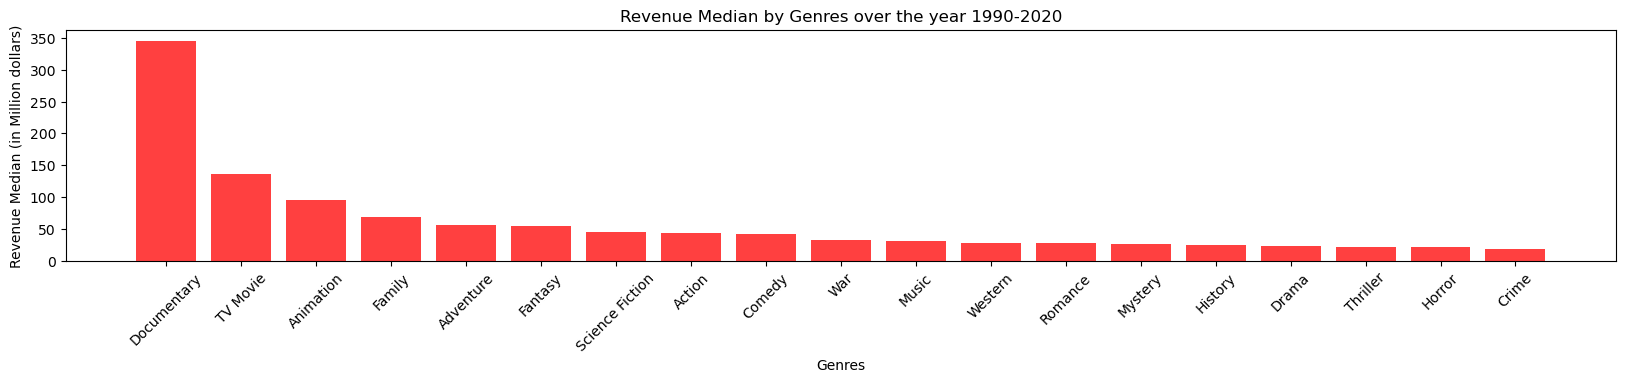

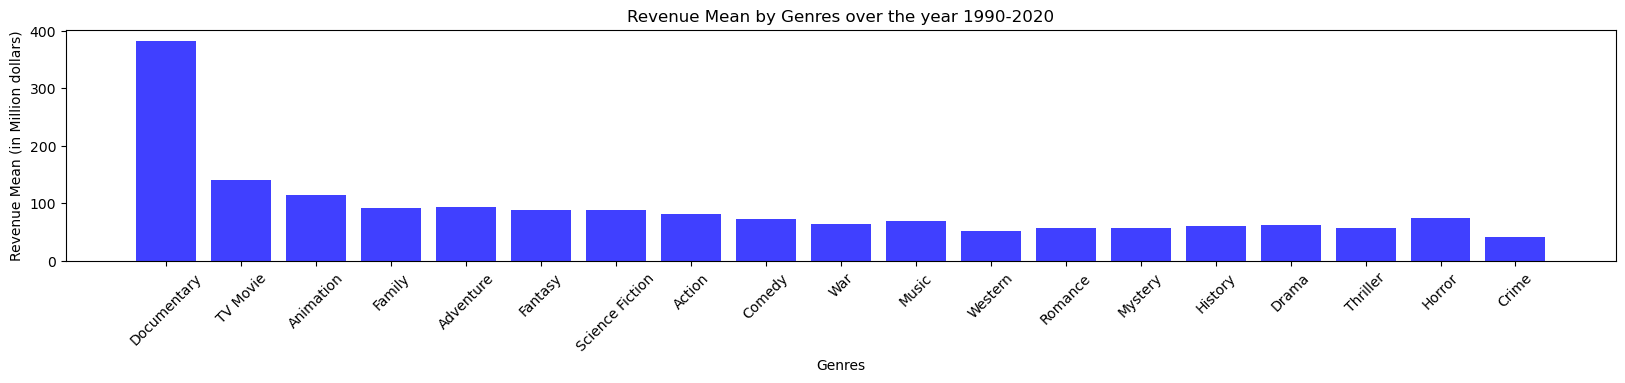

In [18]:
# Create a bar chart to show revenue median for each genre arranged in decending order
x_axis = np.arange(len(revenue_stats))
tick_locations = [value+0.4 for value in x_axis]
y_axis = revenue_stats["Median of Divided Revenue"]

# Plotting a bar chart
plt.figure(figsize=(20,3))
plt.bar(x_axis, revenue_stats["Median of Divided Revenue"]/1000000, color='r', alpha=0.75, align="edge")
plt.xticks(tick_locations, revenue_stats["Genre"], rotation=45)
plt.title("Revenue Median by Genres over the year 1990-2020")
plt.xlabel("Genres")
plt.ylabel("Revenue Median (in Million dollars)")
plt.show()

# Plotting a bar chart
plt.figure(figsize=(20,3))
plt.bar(x_axis, revenue_stats["Mean of Divided Revenue"]/1000000, color='blue', alpha=0.75, align="edge")
plt.xticks(tick_locations, revenue_stats["Genre"], rotation=45)
plt.title("Revenue Mean by Genres over the year 1990-2020")
plt.xlabel("Genres")
plt.ylabel("Revenue Mean (in Million dollars)")
plt.show()

# Upon reviewing these results we were worried a comparison by median or mode would leave out too much data. To understand the data better we created a box plot with the revenues of each movie organized by the different genres 

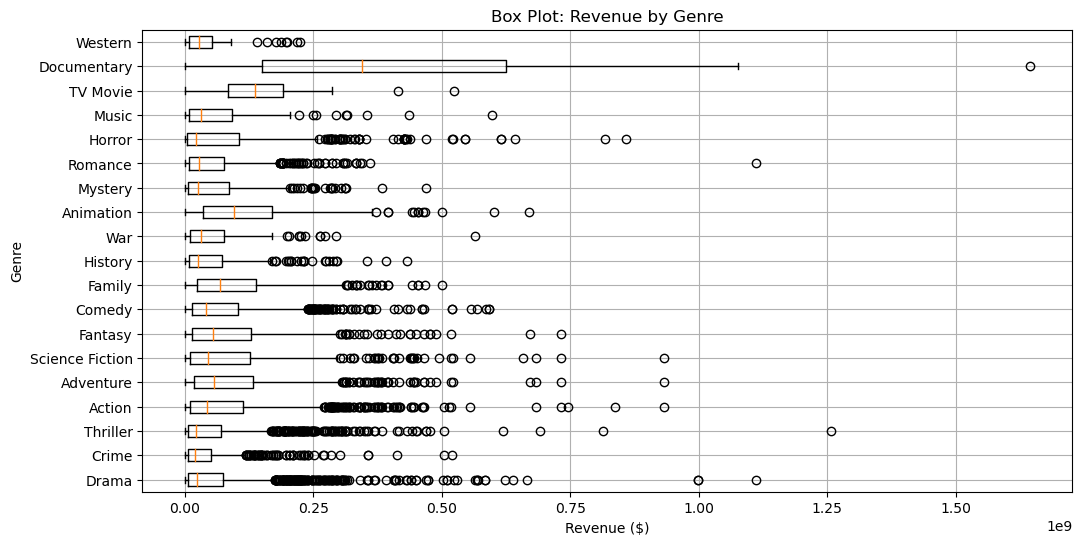

In [19]:
# Set the figure size and create subplots
plt.figure(figsize=(12, 6))

# Box plot for Revenue by Genre 
plt.boxplot([genre_df[genre_df["Genre"] == genre]["Revenue"] for genre in genre_df["Genre"].unique()], labels=genre_df["Genre"].unique(), vert=False)
plt.xlabel("Revenue ($)")
plt.ylabel("Genre")
plt.title("Box Plot: Revenue by Genre")
plt.tick_params(axis='y', rotation=0)
plt.grid(True)

# As you can see above there are a high number of data points condsidered as "outliers". Such a higher number that we decided that comparing the genres by median or mean would not be best for our purposes

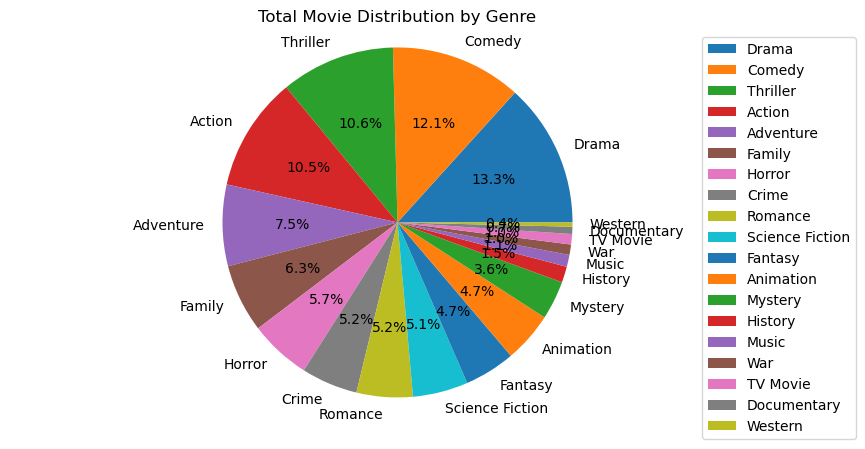

In [22]:
# Sort number of movies per genre in descending order
revenue_stats= revenue_stats.sort_values(by="Genre Count", ascending=False)

# Plotting the pie chart
plt.figure(figsize=(10, 5))
plt.pie(revenue_stats["Genre Count"], labels=revenue_stats["Genre"], autopct='%1.1f%%')
plt.legend(loc="upper right", bbox_to_anchor=(1.1, 1))
plt.title("Total Movie Distribution by Genre")
plt.axis("equal")
plt.show()

# Without a clear statistical rationale for how to compare the revenues from the different genres we decided to use the top 5 genres by total movies. Which, as you can see above, account for over 50% of the movies made in the date range we're focused on

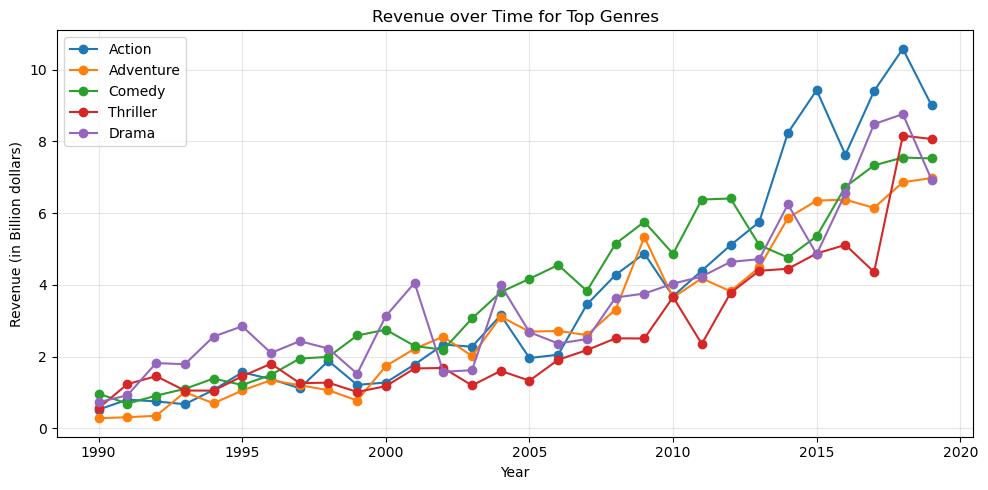

In [24]:
# Sort by tthe sum of the divided revenue for each genre
revenue_stats = revenue_stats.sort_values(by="Sum of Divided Revenue", ascending=False)

# Create a list of genres
genres = ["Action", "Adventure", "Comedy", "Thriller", "Drama"]
# Create a figure for the plot
plt.figure(figsize=(10, 5))
# Iterate over each genre
for genre in genres:
    # Filter the DataFrame for the current genre
    genre_filter_df = genre_df[genre_df["Genre"] == genre]
    # Group by year and calculate the median revenue for each year
    genre_revenue_df = genre_filter_df.groupby("Year")["Revenue"].sum().reset_index()
    # Plot median revenue for the current genre
    plt.plot(genre_revenue_df["Year"], genre_revenue_df["Revenue"]/1000000000, marker="o", linestyle="-", label=genre)
# Add title and labels
plt.title("Revenue over Time for Top Genres")
plt.xlabel("Year")
plt.ylabel("Revenue (in Billion dollars)")
plt.legend()
plt.grid(True, alpha=0.3)
# Show plot
plt.tight_layout()
plt.show()

# With the top genres settled on we are able to compare their revenues over the chosen date range. As you can see above since 1990 revenues for all the top genres have increased with clear shifts in the top genre through out the decades.

In [28]:
nineties_df = genre_df.loc[(genre_df["Year"] >= 1990) & (genre_df["Year"] <= 1999)]
twenties_df = genre_df.loc[(genre_df["Year"] >= 2000) & (genre_df["Year"] <= 2009)]
twentyone_df = genre_df.loc[(genre_df["Year"] >= 2010) & (genre_df["Year"] <= 2019)]

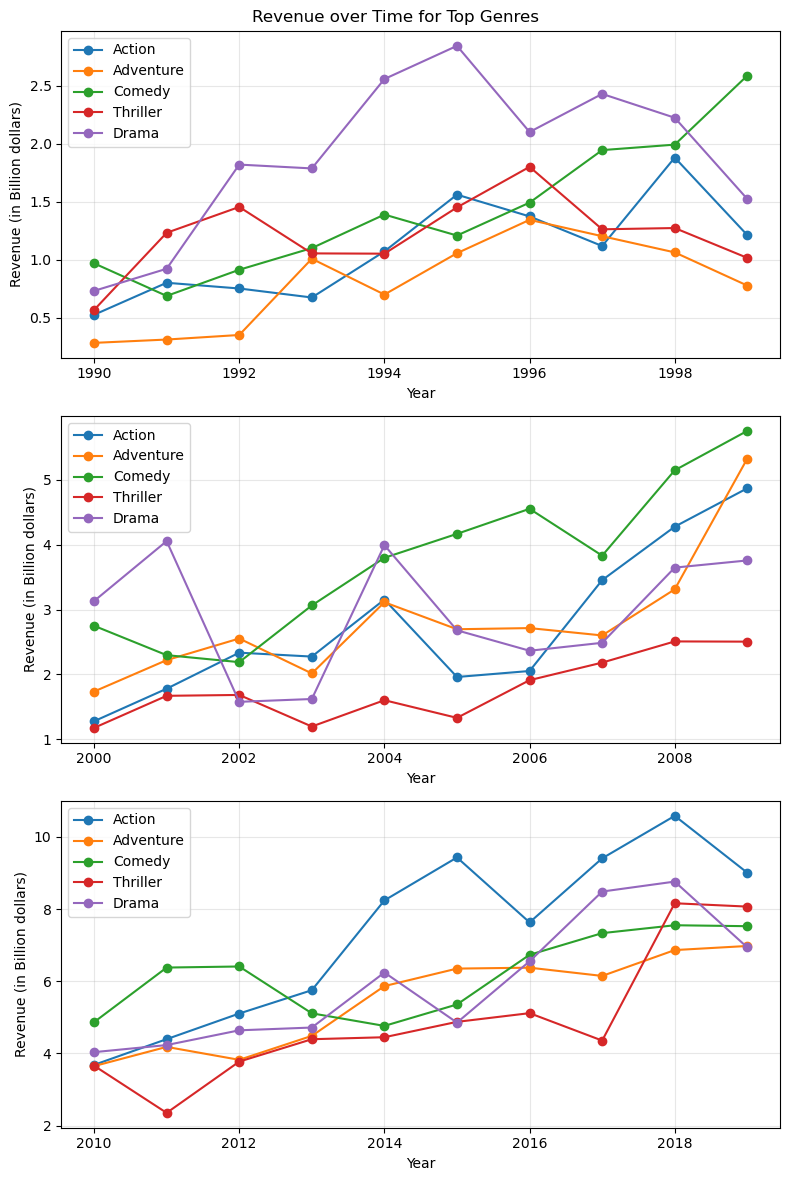

In [29]:
# Plot three decades in one figure
# Create a list of genres
genres = ["Action", "Adventure", "Comedy", "Thriller", "Drama"]

# Create a figure with three subplots arranged in a column.
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Iterate over each decade and subplot index
for df, ax in zip([nineties_df, twenties_df, twentyone_df], axs):
    # Iterate over each genre
    for genre in genres:
        # Filter the DataFrame for the current genre and decade
        filter_df = df[df["Genre"] == genre]
        # Group by year and calculate the sum of revenue for each year
        genre_revenue_df = filter_df.groupby("Year")["Revenue"].sum().reset_index()
        # Plot the revenue for the current genre and decade
        ax.plot(genre_revenue_df["Year"], genre_revenue_df["Revenue"]/1000000000, marker="o", linestyle="-", label=genre)

    # Add labels to each subplot
    ax.set_xlabel("Year")
    ax.set_ylabel("Revenue (in Billion dollars)")
    ax.legend()
    ax.grid(True, alpha=0.3)

# Add title to the figure
fig.suptitle("Revenue over Time for Top Genres")

# Adjust layout and display plot
plt.tight_layout()
plt.show()

 # By creating these line plots focused on each decade individually we can see in greater detail how the genre leading in revenue has shifted with drama leading for most of the 90s, comedey leading for most of the 2000s, and action leading for most of the 2010s 

# Part 3: Examining the relationship between genre popularity and Disposable Personal Income

# Question: How does disposable personal income influence the popularity of different movie genres?
** DPI is amount of money that an individual or household has to spend or save after income taxes have been deducted

In [ ]:
# Genre column was cleaned by removing whitespace and converting it to lowercase 
genre_df["Genre"] = genre_df["Genre"].str.strip().str.lower()
selected_genres = ["action", "adventure", "comedy", "thriller", "drama"]
# Data Frame was filtered to include only our selected_genres
df_genre_filtered = genre_df[genre_df["Genre"].isin(selected_genres)].copy()  # Explicitly create a copy
df_genre_filtered["Genre"] = df_genre_filtered["Genre"].str.capitalize()  # Capitalize genre names
# A new data frame was created by grouping data by "Genre" and "Year"
Final_df_DPI = df_genre_filtered.groupby(["Genre", "Year"], observed=False)[ "Divided Revenue"].sum().reset_index()
Final_df_DPI.head(5)

In [ ]:
# Add new columns to store the retrieved data for DPI
Final_df_DPI['Disposable personal income (DPI)']=""
Final_df_DPI['DPI UNIT MULT']=""
Final_df_DPI.head(5)

In [ ]:
# Set the API base URL
base_url = 'https://apps.bea.gov/api/data/'
# A URL was constructed to make an API request to retrieve data related to DPI 
params ={ 'UserID': api_key,
    'method': 'GetData',
    'datasetname': 'REGIONAL',
    'TableName': 'SAINC51',
    'Frequency': 'A',
    'GeoFips': '00000',
    'LineCode': 'All',
    'ResultFormat': 'JSON'  
}
# Each row in the DataFrame was iterated over
for i, row in Final_df_DPI.iterrows():
    year = row ["Year"]
    params["Year"]=f"{year}"
    response = requests.get(base_url, params=params).json()
    
    try:
        Final_df_DPI.loc[i, "Disposable personal income (DPI)"] = float(response["BEAAPI"]["Results"]["Data"][0]["DataValue"])
        Final_df_DPI.loc[i, "DPI UNIT MULT"] = float(response["BEAAPI"]["Results"]["Data"][0]["UNIT_MULT"])
    # Broaden the exception handling to catch any exception
    except Exception as e: 
        # Print the error message
        print(f"Error processing {year}: {e.args[0]} not found")  
        Final_df_DPI.loc[i, ["Disposable personal income (DPI)", "DPI UNIT MULT"]] = float("nan")
        pass

    
# Indicate that Data Loading is complete 
print("-----------------------------")
print("Data Retrieval Complete      ")
print("-----------------------------")
Final_df_DPI.head (15)

In [ ]:
# Cleaning the data frame and Dropping rows with missing values (NaN) - if there is any
Final_df_DPI['Disposable personal income (DPI)'] = pd.to_numeric(Final_df_DPI['Disposable personal income (DPI)'], errors='coerce')
Final_df_DPI = Final_df_DPI.dropna()
Final_df_DPI.reset_index(drop=True, inplace=True)
Final_df_DPI.head(5)

# Disposable personal income vs Revenue for different Genres

In [ ]:
# Define functions for plotting the regression 
def regression_plot(x_values, y_values, genre):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(slope) + "x + " + str(round(intercept, 2))
    plt.scatter(x_values, y_values)
    plt.plot(x_values, regress_values, "r-")
    plt.text(x_values.min(), y_values.min(), line_eq, fontsize=12, color="red")
    plt.xlabel('Divided Revenue ($)')
    plt.ylabel('Disposable personal income ($)')
    plt.title(f"Regression: Revenue vs DPI for {genre}")
    plt.show()

# Define functions for calculating and printing the correlation coefficient
def correlation_plot(x_values, y_values, genre):
    correlation = st.pearsonr(x_values, y_values)
    print(f"Correlation for {genre}: {round(correlation[0], 2)}")

# Create a list of genres
genres = ["Action", "Adventure", "Comedy", "Thriller", "Drama"]

# Iterate over each genre
for genre in genres:
    # Filter DataFrame accordingly
    df_genre = Final_df_DPI[Final_df_DPI['Genre'] == genre]    
    x_values = df_genre['Divided Revenue']
    y_values = df_genre['Disposable personal income (DPI)']
    
    # Call regression and correlation functions
    regression_plot(x_values, y_values, genre)
    correlation_plot(x_values, y_values, genre)
    